Total annotations: 21624
 Wisdom teeth annotations (category_id_2 == 7): 2436
Total unique images: 705


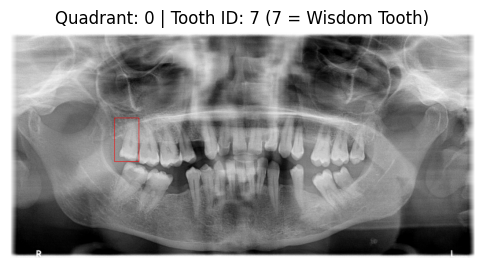

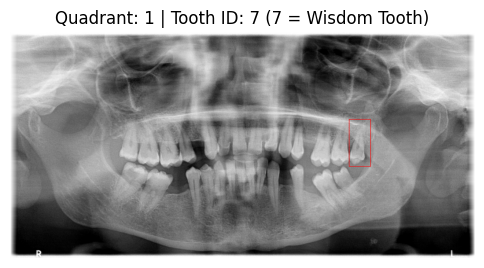

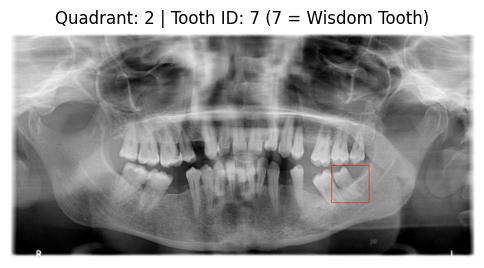

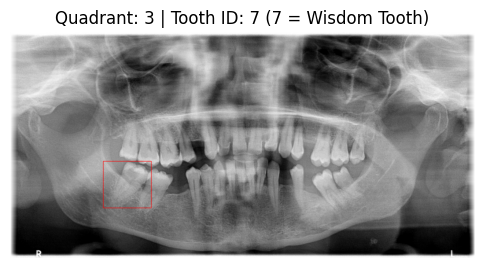

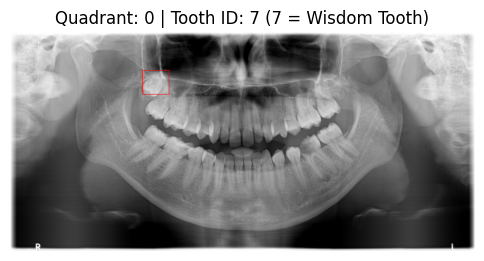

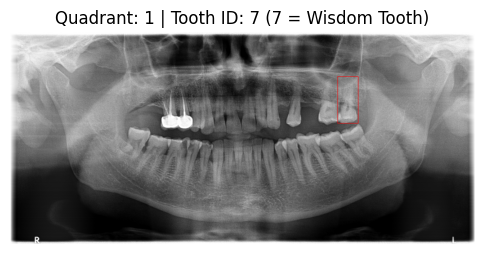

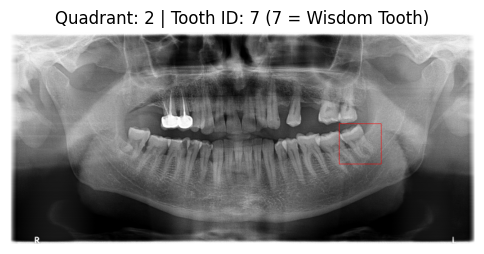

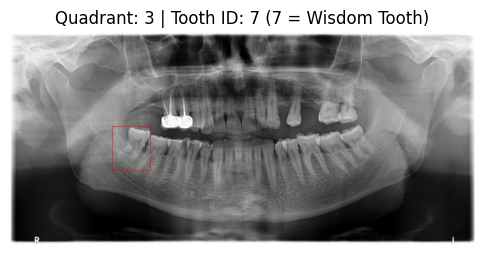

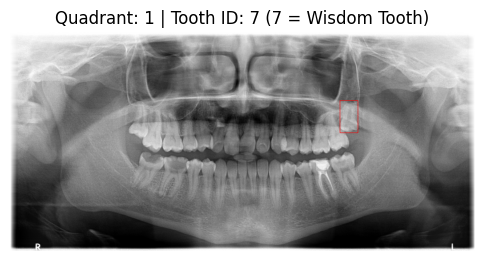

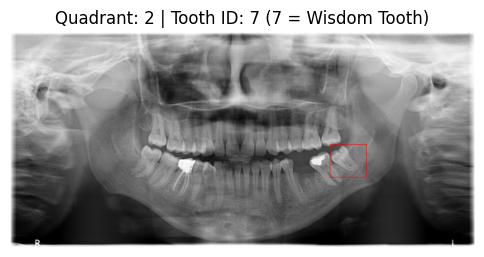

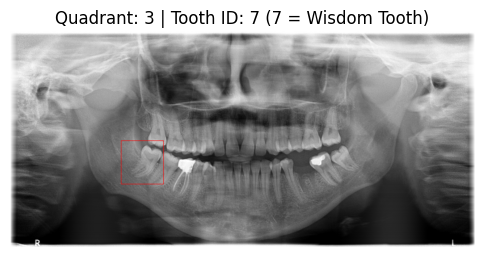

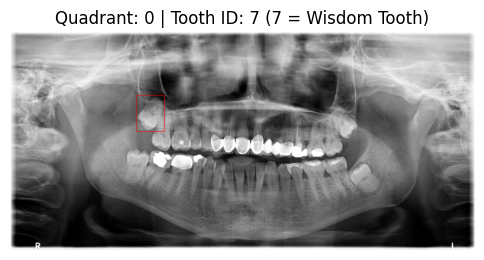

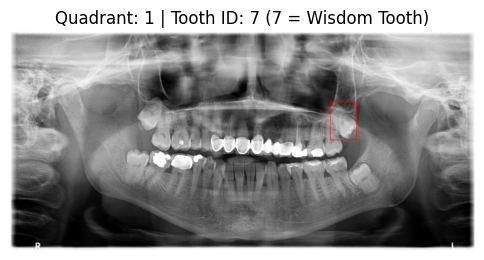

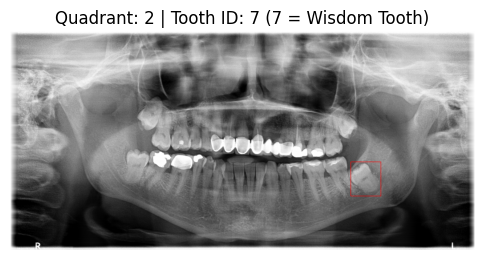

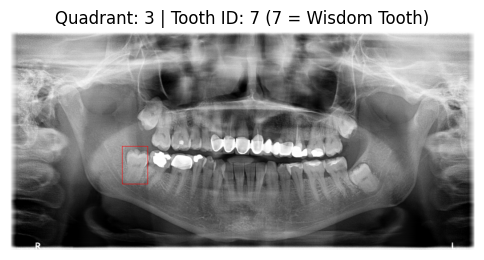

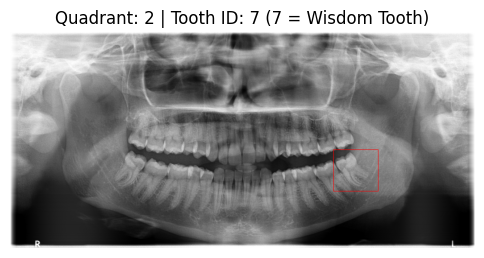

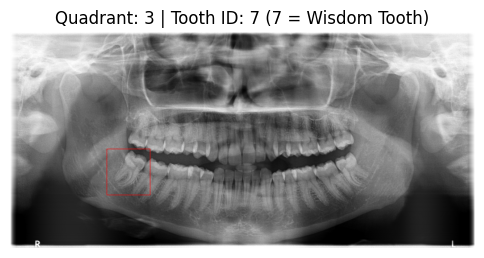

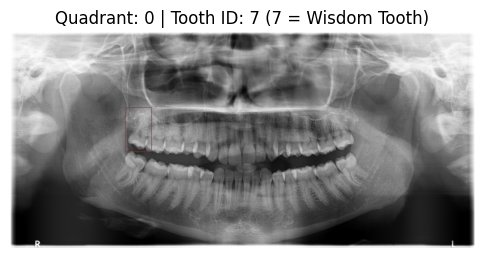

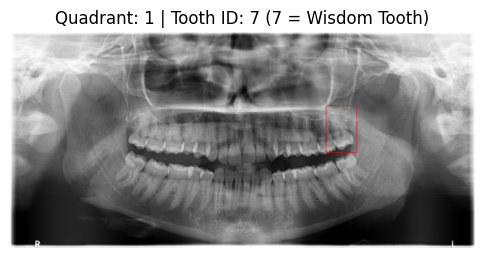

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import cv2

# Root directory of dataset
base_path = "/kaggle/input/dentex-challenge-2023/training_data/training_data"

# Paths to JSON files
json_paths = {
    "enumeration": os.path.join(base_path, "quadrant_enumeration/train_quadrant_enumeration.json"),
    "disease": os.path.join(base_path, "quadrant-enumeration-disease/train_quadrant_enumeration_disease.json")
}

# Paths to corresponding X-ray folders
xray_dirs = {
    "quadrant_enumeration": os.path.join(base_path, "quadrant_enumeration/xrays"),
    "disease": os.path.join(base_path, "quadrant-enumeration-disease/xrays")
}

# Function to load JSON data
def load_data(json_path, source_tag):
    with open(json_path, 'r') as f:
        data = json.load(f)
    images = pd.DataFrame(data["images"])
    images["source"] = source_tag
    annotations = pd.DataFrame(data["annotations"])
    return images, annotations

# Load data from both annotation sources
images_enum, ann_enum = load_data(json_paths["enumeration"], "quadrant_enumeration")
images_disease, ann_disease = load_data(json_paths["disease"], "disease")

# Combine images and annotations
all_images = pd.concat([images_enum, images_disease]).drop_duplicates(subset="id").reset_index(drop=True)
all_annotations = pd.concat([ann_enum, ann_disease]).reset_index(drop=True)

# Filter for wisdom teeth only (category_id_2 == 7)
wisdom_ann = all_annotations[all_annotations["category_id_2"] == 7]
print(f"Total annotations: {len(all_annotations)}")
print(f" Wisdom teeth annotations (category_id_2 == 7): {len(wisdom_ann)}")
print(f"Total unique images: {len(all_images)}")

# Merge to get file paths
wisdom_with_images = pd.merge(wisdom_ann, all_images, left_on="image_id", right_on="id", suffixes=("_ann", "_img"))

# Show examples with bounding boxes
def show_examples(df, n=19):
    for i, row in df.head(n).iterrows():
        source = row["source"]
        image_dir = xray_dirs[source]
        image_path = os.path.join(image_dir, row["file_name"])

        img = cv2.imread(image_path)
        if img is None:
            print(f"Couldn't read image: {image_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        x, y, w, h = map(int, row["bbox"])
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f"Quadrant: {row['category_id_1']} | Tooth ID: {row['category_id_2']} (7 = Wisdom Tooth)")
        plt.axis("off")
        plt.show()

show_examples(wisdom_with_images)


In [2]:
# Get IDs of all images that have at least one wisdom tooth annotation
images_with_wisdom = wisdom_with_images["image_id"].unique()

# Create a label column: 1 for images with wisdom tooth, 0 otherwise
all_images["label"] = all_images["id"].apply(lambda x: 1 if x in images_with_wisdom else 0)

# Count totals
label_counts = all_images["label"].value_counts()
print("Label distribution:")
print(label_counts)

# Optional: Show a few image names for verification
print("\n Sample of labeled images:")
print(all_images[["file_name", "label"]].head())


Label distribution:
label
1    643
0     62
Name: count, dtype: int64

 Sample of labeled images:
       file_name  label
0  train_283.png      1
1  train_435.png      1
2   train_95.png      1
3  train_475.png      1
4   train_62.png      1


In [3]:
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm


2025-08-20 06:28:52.636896: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755671332.994509      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755671333.092628      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# --- Config ---
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42

# --- Step 1: Merge images with labels ---
all_images["path"] = all_images.apply(
    lambda row: os.path.join(xray_dirs[row["source"]], row["file_name"]), axis=1
)
df = all_images[["path", "label"]].copy()
df = df[df["path"].apply(os.path.exists)]  # Remove missing paths

# --- Step 2: Oversample minority class (label 0) ---
majority = df[df.label == 1]
minority = df[df.label == 0]

minority_upsampled = resample(minority,
                               replace=True,
                               n_samples=len(majority),
                               random_state=SEED)

df_balanced = pd.concat([majority, minority_upsampled]).sample(frac=1, random_state=SEED).reset_index(drop=True)

# --- Step 3: Train/val split ---
train_df, val_df = train_test_split(df_balanced, test_size=0.2, stratify=df_balanced["label"], random_state=SEED)

# --- Step 4: Image loading helper ---
def load_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# --- Step 5: Data generator using ImageDataGenerator ---
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True, rotation_range=15)
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

def dataframe_to_generator(df, generator):
    images = np.array([load_image(p) for p in df["path"]])
    labels = to_categorical(df["label"].values, num_classes=2)
    return generator.flow(images, labels, batch_size=BATCH_SIZE, shuffle=True)

train_generator = dataframe_to_generator(train_df, train_gen)
val_generator = dataframe_to_generator(val_df, val_gen)

# --- Step 6: Model setup (ResNet50 base) ---
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation="relu")(x)
output = Dense(2, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

# --- Step 7: Compile ---
model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

# --- Step 8: Train ---
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop],
    verbose=1
)


I0000 00:00:1755671454.788582      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755671454.789243      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1755671506.286385     106 service.cc:148] XLA service 0x79bf48017420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755671506.288393     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755671506.288422     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755671511.013560     106 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755671532.108003     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.6453 - loss: 0.5926 - val_accuracy: 0.6899 - val_loss: 0.8393
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 346ms/step - accuracy: 0.9417 - loss: 0.1868 - val_accuracy: 0.7829 - val_loss: 0.8239
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 339ms/step - accuracy: 0.9502 - loss: 0.1602 - val_accuracy: 0.7674 - val_loss: 0.8661
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 340ms/step - accuracy: 0.9624 - loss: 0.1180 - val_accuracy: 0.8023 - val_loss: 1.1148
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 349ms/step - accuracy: 0.9398 - loss: 0.1916 - val_accuracy: 0.8411 - val_loss: 0.6711
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 374ms/step - accuracy: 0.9732 - loss: 0.0849 - val_accuracy: 0.7868 - val_loss: 0.7051
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 365ms/step - accuracy: 0.9647 - loss: 0.1134 - val_accuracy: 0.8411 - val_loss: 0.4624
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 356ms/step - accuracy: 0.9742 - loss: 0.0746 - val_accuracy: 0.8915 

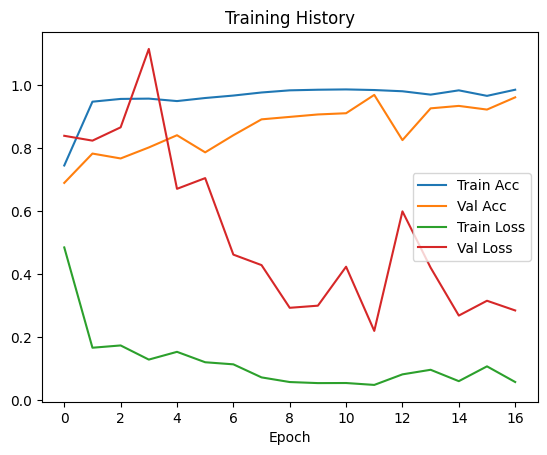

In [5]:
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Training History")
plt.xlabel("Epoch")
plt.show()
